Step 1: Import Libraries and Set Constants

In [4]:
import math
import random
import sys
import os
import pygame
import neat
import matplotlib.pyplot as plt

# Constants
WIDTH = 1920
HEIGHT = 1080
CAR_SIZE_X = 60
CAR_SIZE_Y = 60
BORDER_COLOR = (255, 255, 255, 255)
current_generation = 0
Q = {}  # Q-table for storing Q-values
fitness_values = []

Step 2: Define the Car Class

In [5]:
class Car:
    def __init__(self):
        self.sprite = pygame.image.load('car.png').convert()
        self.sprite = pygame.transform.scale(self.sprite, (CAR_SIZE_X, CAR_SIZE_Y))
        self.rotated_sprite = self.sprite
        self.position = [830, 920]
        self.angle = 0
        self.speed = 0
        self.speed_set = False
        self.center = [self.position[0] + CAR_SIZE_X / 2, self.position[1] + CAR_SIZE_Y / 2]
        self.radars = []
        self.drawing_radars = []
        self.alive = True
        self.distance = 0
        self.time = 0

    def draw(self, screen):
        screen.blit(self.rotated_sprite, self.position)
        self.draw_radar(screen)

    def draw_radar(self, screen):
        for radar in self.radars:
            position = radar[0]
            pygame.draw.line(screen, (0, 255, 0), self.center, position, 1)
            pygame.draw.circle(screen, (0, 255, 0), position, 5)

    def check_collision(self, game_map):
        self.alive = True
        for point in self.corners:
            if game_map.get_at((int(point[0]), int(point[1]))) == BORDER_COLOR:
                self.alive = False
                break

    def check_radar(self, degree, game_map):
        length = 0
        x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * length)
        y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * length)

        while not game_map.get_at((x, y)) == BORDER_COLOR and length < 300:
            length += 1
            x = int(self.center[0] + math.cos(math.radians(360 - (self.angle + degree))) * length)
            y = int(self.center[1] + math.sin(math.radians(360 - (self.angle + degree))) * length)

        dist = int(math.sqrt(math.pow(x - self.center[0], 2) + math.pow(y - self.center[1], 2)))
        self.radars.append([(x, y), dist])

    def update(self, game_map):
        if not self.speed_set:
            self.speed = 20
            self.speed_set = True

        self.rotated_sprite = self.rotate_center(self.sprite, self.angle)
        self.position[0] += math.cos(math.radians(360 - self.angle)) * self.speed
        self.position[0] = max(self.position[0], 20)
        self.position[0] = min(self.position[0], WIDTH - 120)

        self.distance += self.speed
        self.time += 1

        self.position[1] += math.sin(math.radians(360 - self.angle)) * self.speed
        self.position[1] = max(self.position[1], 20)
        self.position[1] = min(self.position[1], HEIGHT - 120)

        self.center = [int(self.position[0]) + CAR_SIZE_X / 2, int(self.position[1]) + CAR_SIZE_Y / 2]

        length = 0.5 * CAR_SIZE_X
        left_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 30))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 30))) * length]
        right_top = [self.center[0] + math.cos(math.radians(360 - (self.angle + 150))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 150))) * length]
        left_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 210))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 210))) * length]
        right_bottom = [self.center[0] + math.cos(math.radians(360 - (self.angle + 330))) * length, self.center[1] + math.sin(math.radians(360 - (self.angle + 330))) * length]
        self.corners = [left_top, right_top, left_bottom, right_bottom]

        self.check_collision(game_map)
        self.radars.clear()

        for d in range(-90, 120, 45):
            self.check_radar(d, game_map)

    def get_data(self):
        radars = self.radars
        return_values = [0, 0, 0, 0, 0]
        for i, radar in enumerate(radars):
            return_values[i] = int(radar[1] / 30)
        return return_values

    def is_alive(self):
        return self.alive

    def get_reward(self):
        return self.distance / (CAR_SIZE_X / 2)

    def rotate_center(self, image, angle):
        rectangle = image.get_rect()
        rotated_image = pygame.transform.rotate(image, angle)
        rotated_rectangle = rectangle.copy()
        rotated_rectangle.center = rotated_image.get_rect().center
        rotated_image = rotated_image.subsurface(rotated_rectangle).copy()
        return rotated_image

    def get_state(self):
        return (int(self.position[0] / 10), int(self.position[1] / 10), self.angle, self.speed)

    def get_action(self, state):
        if state not in Q:
            Q[state] = [0, 0, 0, 0]  # Initialize Q-values for this state
        return Q[state].index(max(Q[state]))  # Choose the action with the highest Q-value

    def update_q_values(self, state, action, next_state, reward):
        if state not in Q:
            Q[state] = [0, 0, 0, 0]
        if next_state not in Q:
            Q[next_state] = [0, 0, 0, 0]
        alpha = 0.1  # Learning rate
        gamma = 0.9  # Discount factor
        Q[state][action] = Q[state][action] + alpha * (reward + gamma * max(Q[next_state]) - Q[state][action])


Step 3: Define the Simulation Function and Initialize the NEAT Algorithm

In [6]:
def run_simulation(genomes, config):
    global current_generation
    current_generation += 1

    nets = []
    cars = []

    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT), pygame.FULLSCREEN)
    clock = pygame.time.Clock()
    generation_font = pygame.font.SysFont("Arial", 30)
    alive_font = pygame.font.SysFont("Arial", 20)
    game_map = pygame.image.load('map.png').convert()

    for i, g in genomes:
        net = neat.nn.FeedForwardNetwork.create(g, config)
        nets.append(net)
        g.fitness = 0
        cars.append(Car())

    counter = 0

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                sys.exit(0)

        for i, car in enumerate(cars):
            state = car.get_state()
            action = car.get_action(state)
            output = nets[i].activate(car.get_data())
            choice = output.index(max(output))
            if choice == 0:
                car.angle += 10
            elif choice == 1:
                car.angle -= 10
            elif choice == 2:
                if car.speed - 2 >= 12:
                    car.speed -= 2
            else:
                car.speed += 2
            next_state = car.get_state()
            reward = car.get_reward()
            car.update_q_values(state, action, next_state, reward)

        still_alive = 0
        for i, car in enumerate(cars):
            if car.is_alive():
                still_alive += 1
                car.update(game_map)
                genomes[i][1].fitness += car.get_reward()

        if still_alive == 0:
            fitness_values.append(stats.get_best_genome().fitness)

            plt.figure()
            plt.plot(fitness_values, label='Fitness')
            plt.xlabel('Generation')
            plt.ylabel('Fitness')
            plt.title('Fitness of Best Genome per Generation')
            plt.legend()
            plt.grid(True)
            plt.show()

            break

        counter += 1
        if counter == 30 * 40:
            break

        screen.blit(game_map, (0, 0))
        for car in cars:
            if car.is_alive():
                car.draw(screen)

        text = generation_font.render("Generation: " + str(current_generation), True, (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (900, 450)
        screen.blit(text, text_rect)

        text = alive_font.render("Still Alive: " + str(still_alive), True, (0, 0, 0))
        text_rect = text.get_rect()
        text_rect.center = (900, 490)
        screen.blit(text, text_rect)

        pygame.display.flip()
        clock.tick(60)

    pygame.quit()

if __name__ == "__main__":
    config_path = "./config.txt"
    config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                                 neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)

    population = neat.Population(config)
    population.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    population.add_reporter(stats)

    population.run(run_simulation, 1000)



 ****** Running generation 0 ****** 

Population's average fitness: 9727.03778 stdev: 51867.30766
Best fitness: 289039.33333 - size: (4, 20) - species 1 - id 9
Average adjusted fitness: 0.034
Mean genetic distance 1.099, standard deviation 0.267
Population of 30 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    30  289039.3    0.034     0
Total extinctions: 0
Generation time: 21.954 sec

 ****** Running generation 1 ****** 

Population's average fitness: 29475.97778 stdev: 86548.64836
Best fitness: 289039.33333 - size: (4, 20) - species 1 - id 9
Average adjusted fitness: 0.102
Mean genetic distance 0.867, standard deviation 0.291
Population of 30 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    30  289039.3    0.102     1
Total extinctions: 0
Generation time: 27.156 sec (24.555 average)

 ****** Running generation 2 ****** 

Population's averag

In [14]:
with open('OUTPUT.txt') as f:
    text = f.read()

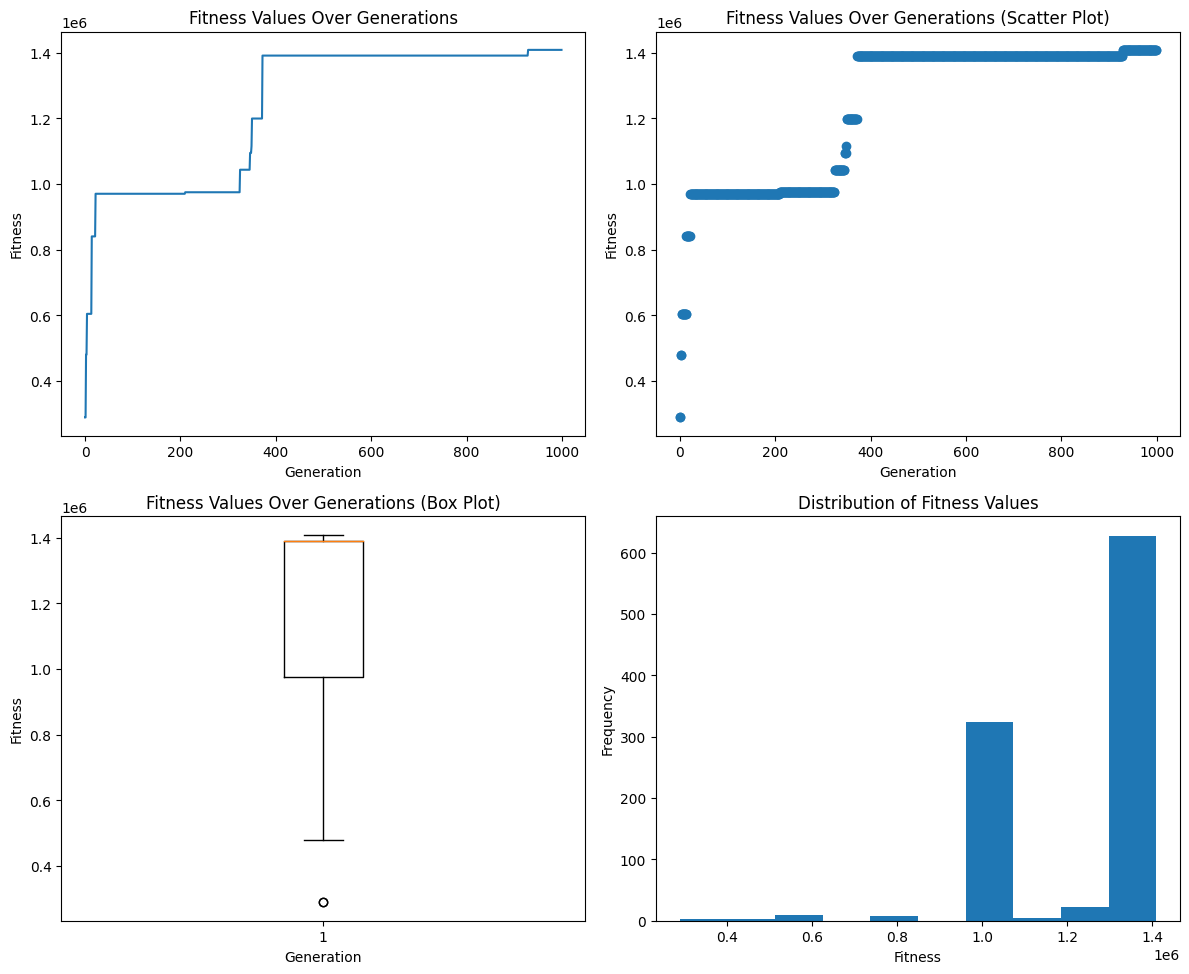

In [19]:
import re
import matplotlib.pyplot as plt

# Extract the fitness values from the text
fitness_values = []
for line in text.split('\n'):
    match = re.search(r'Best fitness: (\d+\.\d+)', line)
    if match:
        fitness_values.append(float(match.group(1)))

# Create a 2x2 grid of plots
plt.figure(figsize=(12, 10))

# Plot 1: Line plot of fitness values over generations
plt.subplot(2, 2, 1)
plt.plot(fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Values Over Generations')

# Plot 2: Scatter plot of fitness values over generations
plt.subplot(2, 2, 2)
plt.scatter(range(len(fitness_values)), fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Values Over Generations (Scatter Plot)')

# Plot 3: Box plot of fitness values over generations
plt.subplot(2, 2, 3)
plt.boxplot(fitness_values)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Values Over Generations (Box Plot)')

# Plot 4: Histogram of fitness values
plt.subplot(2, 2, 4)
plt.hist(fitness_values, bins=10)
plt.xlabel('Fitness')
plt.ylabel('Frequency')
plt.title('Distribution of Fitness Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()